Neste notebook:
* Avaliação de usuários por bucket  
    * em média, e mediana, em quantos buckets os utilizadores estão.  
    * quantos usuários novos estão em cada bucket e quantos não ocorrem

Objetivo:
* explorar caracteristicas dos datasets que permitam
    * avaliar se o dataset é util para a análise  
    * escolher o número de buckets  

Vamos definir o numero de itens em cada bucket como 50k

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData
from recommenders_implicit import ISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateAndStore # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout
from dataset_evaluation_utils import * #get_interactions_info, plot_interactions_per_month, plot_user_presence_distribution, plot_n_users_per_bucket, plot_bucket_size

from datetime import datetime, timedelta

import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
# Amazon Kindle_store
Small subset, ratings only.  
https://nijianmo.github.io/amazon/index.html


In [3]:
# importa dataset 'amazon kindle store'
data = pd.read_csv("../datasets/Kindle_Store.csv", names=['user_id', 'item_id', 'rating', 'timestamp'])
dataset_name = 'Amazon_Kindle_Store'
user_col = 'user_id'

In [4]:
data.shape

(5722988, 4)

In [5]:
data.head()

,user_id,item_id,rating,timestamp
0,1423600150,A27UD5HYAKBL97,4.0,1356739200
1,1423600150,A8P5DK8LLOYGH,5.0,1330992000
2,1423600150,A3OM9W7DXSUIIY,5.0,1250035200
3,1423600150,A3DPAR2PWB9BT8,3.0,1162512000
4,1423600150,A2ONTBSAX7GIOV,5.0,1144713600


### Keep only high ratings

<AxesSubplot:ylabel='Frequency'>

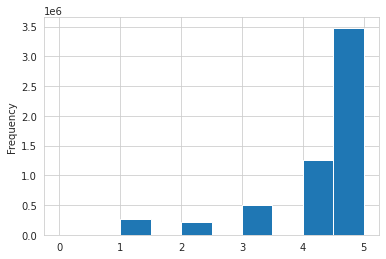

In [6]:
data['rating'].plot(kind='hist')

In [7]:
pos_ratings = np.quantile(data['rating'], q=0.8)

In [8]:
pos_ratings

5.0

In [9]:
data = data[ data['rating'] == pos_ratings ].drop(columns='rating')

In [10]:
# number of remaining cases
data.shape[0]

3479780

### Convert timestamp

In [11]:
%%time
data['date'] = data['timestamp'].apply(lambda x: datetime.fromtimestamp(x) ) # convert unix timestamp to date
data = data.sort_values(by='date') # sort by date

CPU times: user 5.25 s, sys: 418 ms, total: 5.67 s
Wall time: 5.79 s


In [12]:
data.head()

,user_id,item_id,timestamp,date
3957826,B009DRL8LG,A1IBL0XQRJ200W,871603200,1997-08-15
92533,B0046A9VX2,A2KTTIY7HSLBFV,872208000,1997-08-22
3365139,B01D6NM4VA,A3IMAGCSRXL12Y,872208000,1997-08-22
3599648,B003YJEWLM,A1OFN8369L3EP2,872553600,1997-08-26
80659,B003R4ZOP2,A20UN1U2RQ0Y36,872640000,1997-08-27


In [13]:
data.tail()

,user_id,item_id,timestamp,date
5717958,B01HCB4LFE,A3S8GNGO2T7VEQ,1538352000,2018-10-01
5698088,B01GLZGGRI,AHXGHTNAI6VR8,1538352000,2018-10-01
5694162,B01GGCYJ16,A3L9TMJW3EJRJE,1538352000,2018-10-01
5716270,B01HAKH654,A2XP39MF3QAZV0,1538438400,2018-10-02
5711666,B01H45TR0M,A2N5017ICZCW2L,1538438400,2018-10-02


In [14]:
# keep year-month
data['date'] = data['date'].apply(lambda x: datetime.strptime( str(x.year)+'-'+str(x.month), '%Y-%m' ))

## Evaluating Time defined Buckets 

Sampling the dataset

In [15]:
%%time
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()

CPU times: user 1.76 s, sys: 16.7 ms, total: 1.77 s
Wall time: 1.77 s


<AxesSubplot:xlabel='date'>

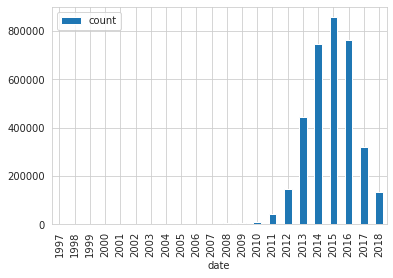

In [16]:
_ = interactions_per_month.copy()
_['date'] = _['date'].dt.year
_.groupby('date').sum().plot(kind='bar')

In [17]:
y_filter = (data['date'] < datetime.strptime('2014-04', '%Y-%m')) & (datetime.strptime('2014', '%Y') <= data['date']) 
# y_filter = (data['date'] < datetime.strptime('2015', '%Y')) & (datetime.strptime('2014', '%Y') <= data['date']) 

In [18]:
data = data[y_filter]

In [19]:
# number of remaining cases
data.shape[0]

166612

Sampling the dataset - only most frequent users (overall)

In [20]:
%%time
# ( data[:1000000].groupby(by=['user_id'])['date'].nunique() > 1 ).sum()
user_freq_over_months = data.groupby(by=['user_id'])['date'].nunique()

CPU times: user 119 ms, sys: 228 µs, total: 119 ms
Wall time: 118 ms


<AxesSubplot:ylabel='Frequency'>

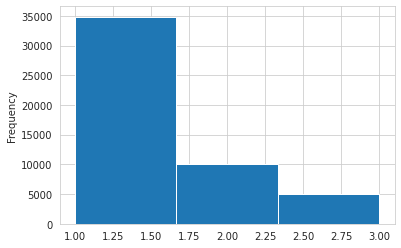

In [21]:
user_freq_over_months.plot(kind='hist',bins=user_freq_over_months.max())

In [22]:
# # we'll filter users with frequency higher than q
# threshold = np.quantile(user_freq_over_months, q=0.5)
# threshold

In [23]:
# # there are this many users with freq above the threshold
# (user_freq_over_months >= threshold).sum()

In [24]:
# # index of frequent users
# freq_users = user_freq_over_months[user_freq_over_months >= threshold].index

In [25]:
# # sample the dataset to contain only interactions from frequent users (that occur every month).
# # there is still a huge number of interactions - 1694351
# _ = data.set_index('user_id').loc[freq_users]
# _.shape
_ = data.set_index('user_id').copy()

<AxesSubplot:>

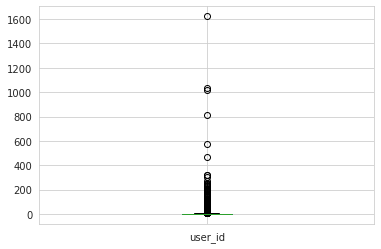

In [26]:
# frequency of users that occur every month:
_.reset_index()['user_id'].value_counts().plot(kind='box')

In [27]:
np.quantile(_.reset_index()['user_id'].value_counts(), 0.9)

6.0

In [28]:
# nu = int( _.reset_index()['user_id'].nunique()*0.0025 ) # 0.05% of users
threshold = np.quantile(_.reset_index()['user_id'].value_counts(), 0.9) #_.reset_index()['user_id'].value_counts().iloc[:nu].min() # sample 5% of users with highest freq, this freq is the threshold
freq_users = _.reset_index()['user_id'].value_counts()[ _.reset_index()['user_id'].value_counts() >= threshold ].index

In [29]:
_.reset_index()['user_id'].value_counts()[ _.reset_index()['user_id'].value_counts() >= threshold ]

B00DMCV7K0    1622
B00ABLJ5X6    1032
B00C2WDD5I    1021
B00EOARZ4G     814
B00ESJ3S94     576
              ... 
B00DPQ174O       6
B00FZ9NCFQ       6
B00HFVMP0K       6
B00IJQRUZK       6
B00H8CLAXY       6
Name: user_id, Length: 5849, dtype: int64

In [30]:
data['user_id'].nunique(), data['item_id'].nunique() # original number of users, original number of items

(49878, 117672)

In [31]:
_.loc[freq_users].reset_index()['user_id'].nunique(), _.loc[freq_users].reset_index()['item_id'].nunique() # sample number of users, and of items

(5849, 70220)

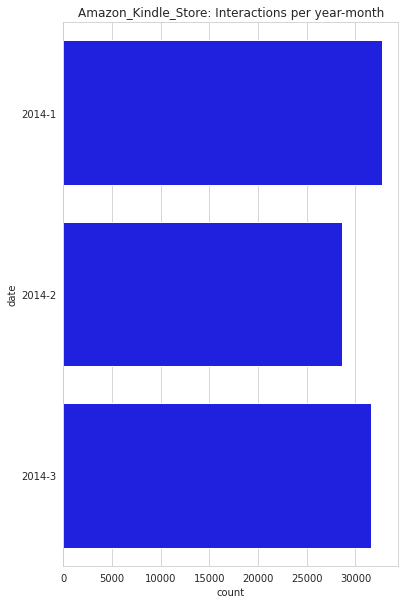

In [32]:
# %%time
plot_interactions_per_month(data=_.loc[freq_users].reset_index(), dataset_name=dataset_name)

In [33]:
# # sample again:
# # the frequency of the 5000th user with most interactions is used as threshold
# nu = int( _.reset_index()['user_id'].nunique()*0.05 ) # 5% of users
# threshold = _.reset_index()['user_id'].value_counts().iloc[:nu].min() # sample 10% of users with highest freq, this freq is the threshold
# freq_users = _.reset_index()['user_id'].value_counts()[ _.reset_index()['user_id'].value_counts() >= threshold ].index

In [34]:
# _.reset_index()['user_id'].value_counts()[ _.reset_index()['user_id'].value_counts() >= threshold ]

In [35]:
# data['user_id'].nunique(), data['item_id'].nunique() # original number of users, original number of items

In [36]:
# _.loc[freq_users].reset_index()['user_id'].nunique(), _.loc[freq_users].reset_index()['item_id'].nunique() # sample number of users, and of items

In [37]:
# previous (huge) sample
# data = data.set_index('user_id').loc[freq_users].reset_index()
# new sample - only 5011 most frequent users, from users that occur in every month
data = _.loc[freq_users].reset_index()

In [38]:
# number of remaining cases
data.shape[0]

92955

In [134]:
# sort by timestamp
# data = data.sort_values(by=['timestamp'])

In [40]:
# previous (huge) sample
# data.to_csv('output/amazonbooks_dump/sampled_amazon_books.csv', index=False)

# new sample
data.to_csv('output/amazonkindle_dump/2nd_sampled_amazon_kindle.csv', index=False)

How many interactions occur in each month / year?

In [41]:
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()

CPU times: user 216 ms, sys: 11.4 ms, total: 227 ms
Wall time: 300 ms


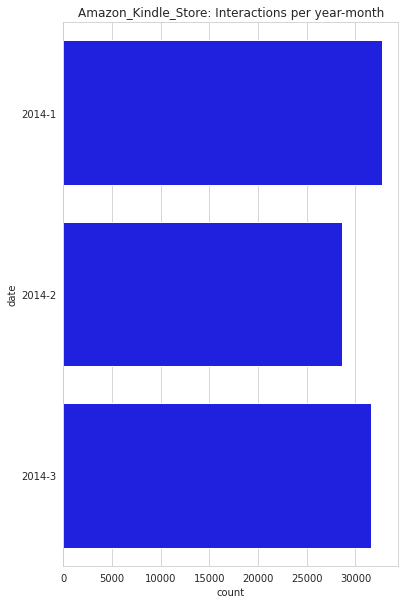

In [42]:
%%time
plot_interactions_per_month(data=data, dataset_name=dataset_name)

What is the user presence distribution based on month, quarter, and semester?

In [43]:
%%time
# 1.66s new sample time
# 1h 11s previous sample time
# user_presence_df, user_month_interactions, trimestres, user_trimestre_interactions, semestres, user_semestre_interactions = get_interactions_info(data=data, user_col=user_col)
user_presence_df, user_month_interactions = get_interactions_info(data=data, user_col=user_col)

# previous huge sample
# user_presence_df.to_csv('output/amazonbooks_dump/user_presence_df.csv', index=False)
# user_month_interactions.to_csv('output/amazonbooks_dump/user_month_interactions.csv', index=False)

# new sample
user_presence_df.to_csv('output/amazonkindle_dump/2nd_sample_user_presence_df.csv', index=False)
user_month_interactions.to_csv('output/amazonkindle_dump/2nd_sample_user_month_interactions.csv', index=False)

# joblib.dump(trimestres, 'output/amazonbooks_dump/2nd_sample_trimestres.joblib' )
# user_trimestre_interactions.to_csv('output/amazonbooks_dump/2nd_sample_user_trimestre_interactions.csv', index=False)

0.0 %
CPU times: user 24.5 s, sys: 3.75 ms, total: 24.5 s
Wall time: 24.8 s


In [44]:
user_presence_df.head()

,UserID,month_%
0,B000FBFMHU,1.0
1,B00HI3MSV6,1.0
2,B007A4V37S,1.0
3,B00HTO0PH8,1.0
4,B007AW2CLG,1.0


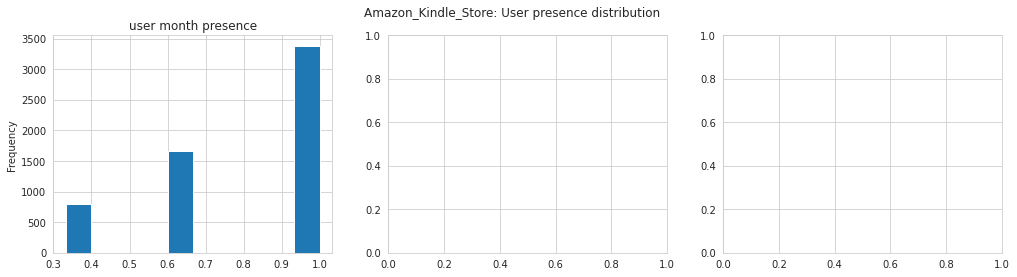

In [45]:
# plotting user frequency distribution
plot_user_presence_distribution(user_presence_df, dataset_name=dataset_name)

How many examples are there per quarter and semester?

In [46]:
# plot_interactions_per_qns(user_interactions=user_trimestre_interactions, date_range=trimestres, dataset_name=dataset_name, type_of_range='quarter')

In [47]:
# plot_interactions_per_qns(user_interactions=user_semestre_interactions, date_range=semestres, dataset_name=dataset_name, type_of_range='semester')

How many FREQUENT users (occur in 80% or more intervals) exist?

In [48]:
# defining threshold
frequency_threshold = 0.8

In [49]:
# frequent_users_month, frequent_users_trimestre, frequent_users_semestre = get_frequent_users(user_presence_df, frequency_threshold=frequency_threshold)
frequent_users_month = get_frequent_users(user_presence_df, frequency_threshold=frequency_threshold)

3385 users of 5849 (57.873%) occurr in 80.0% or more months.


In [50]:
# old huge sample
# joblib.dump(frequent_users_month, 'output/amazonbooks_dump/frequent_users_month.joblib')

# new sample
joblib.dump(frequent_users_month, 'output/amazonkindle_dump/2nd_sample_frequent_users_month.joblib')

['output/amazonkindle_dump/2nd_sample_frequent_users_month.joblib']

In median terms, how many times FREQUENT users appear in each quarter, and semester?

In [147]:
# freq_user_quarter_info = get_frequent_user_statistics(
#     interactions_df=user_trimestre_interactions, frequent_users_list=frequent_users_trimestre)
# # freq_user_quarter_info

In [148]:
# freq_user_quarter_info['median_freq_user_interactions'].plot(kind='bar')

In [149]:
# freq_user_quarter_info['freq_users_at_least_1_interaction'].plot(kind='bar')

In [39]:
# # frequent user interaction per quarter
# plot_interactions_per_qns(user_interactions=user_trimestre_interactions.loc[frequent_users_trimestre],
#     date_range=trimestres)

In [150]:
# freq_user_semester_info = get_frequent_user_statistics(
#     interactions_df=user_semestre_interactions, frequent_users_list=frequent_users_semestre)
# # freq_user_semester_info

In [151]:
# freq_user_semester_info['median_freq_user_interactions'].plot(kind='bar')

In [152]:
# freq_user_semester_info['freq_users_at_least_1_interaction'].plot(kind='bar')

In [43]:
# plot_interactions_per_qns(user_interactions=user_semestre_interactions.loc[frequent_users_semestre], date_range=semestres, type_of_range='semester')

In [153]:
# # these are the users that should be used in holdouts, and only their last interactions
# # BUT, there are users that do not appear in some intervals, and some have only one interaction
# user_trimestre_interactions.loc[frequent_users_trimestre]
# user_semestre_interactions.loc[frequent_users_semestre];

## Evaluating Interactions 50E3 sized Buckets 

In [154]:
# n_iter_bucket = 50E3

# interval_start, interval_end = get_bucket_intervals(data, n_iter_bucket)    

How many users per bucket?    

In [155]:
# plot_users_per_fixed_bucket(data, user_col, interval_start, interval_end)

How many FREQUENT users (occur in 80% or more intervals) exist?

In [156]:
# %%time
# # 2h 52min 2s
# user_bucket_interactions_df, dates_fixed_buckets_df = get_fixed_buckets_info(data, user_col, interval_start, interval_end)

In [157]:
# frequency_threshold = 0.8

In [158]:
# frequent_users_bucket = get_frequent_users_fixed_buckets(user_bucket_interactions_df, frequency_threshold)

In median terms, how many times FREQUENT users appear in each bucket?

In [159]:
# freq_user_bucket_info = get_frequent_user_statistics(user_bucket_interactions_df, frequent_users_bucket)

In [160]:
# freq_user_bucket_info['median_freq_user_interactions'].plot(kind='bar')

In [161]:
# freq_user_bucket_info['freq_users_at_least_1_interaction'].plot(kind='bar')

In [162]:
# # frequent users interactions per bucket
# plot_user_interactions_per_bucket(user_bucket_interactions_df, frequent_users_bucket)

Which timestamps occur in each bucket?

In [163]:
# plot_timestamps_per_bucket(dates_fixed_buckets_df)

___
## Store Buckets

In [164]:
# # transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte.
# # recebe listas
# stream = ImplicitData(data['user_id'], data['item_id'])

# empty_stream = ImplicitData([], [])

In [165]:
# num_factors = 160
# num_iter = 4
# learn_rate = 0.5
# regularization = 0.4
# num_nodes = 8

In [166]:
# # O modelo não pode conter o stream, deve ser iniciado com uma lista vazia
# # Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
# model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [167]:
# n_holdouts = int( data.shape[0]/n_iter_bucket )
# eval_lastfm = EvaluateAndStore(model=model, data=stream, n_holdouts=n_holdouts, metrics = ["Recall@N"], N_recommendations=20, seed=42)

In [168]:
# _=eval_lastfm.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True) # 441 min

In [ ]:
# joblib.dump(eval_lastfm, 'output/joblib_bucket_info_dump/eval_lastfm', compress=True)